<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1729273000/Group_4.png" alt="Logo" width="30%">
  </a>
</div>

### üñπ Descripci√≥n:
Este Proyecto tiene como objetivo aplicar redes neuronales convolucionales (CNN) para realizar una clasificaci√≥n multiclase de im√°genes mediante aprendizaje supervisado. Utilizando el [Covid-19 Image Dataset de Kaggle](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset), que contiene im√°genes de rayos X clasificadas en tres categor√≠as (Covid-19, Normal, Neumon√≠a), en este proyecto se desarrollar√°n clasificadores capaces de diagnosticar enfermedades pulmonares. El proyecto tambi√©n explora el uso de PyTorch para el desarrollo de modelos de Machine Learning y herramientas de monitoreo, como Weights and Biases, para el seguimiento en tiempo real del proceso de entrenamiento.

### ‚úçÔ∏è Autores:
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### üìÖ Fecha:
20 de octubre de 2024

### üìù Notas:
Este es el segundo proyecto del curso IC6200 - Inteligencia Artificial. En este notebook, titulado "Covid-19 Classification", se profundiza en t√©cnicas de data augmentation, preprocesamiento de im√°genes con filtros, y fine-tuning de modelos CNN como VGG16 para mejorar la capacidad de generalizaci√≥n de las redes neuronales convolucionales.

### Otras notas:
Asegurarse de contar con Python y las siguientes bibliotecas instaladas: torch, torchvision, cv2, numpy, matplotlib, Pillow.

# Configurci√≥n

## Importaci√≥n de Librer√≠as

In [146]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

from torchviz import make_dot
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import wandb

from pathlib import Path
import os

## Verificar PyThorch y CUDA

In [147]:
print("CUDA available:", torch.cuda.is_available())
if(torch.cuda.is_available()):
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())

CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
Current GPU: 0


## Configuraci√≥n de Weights & Biases

In [148]:
wandb.init(project="CovMedNet_modelo_b", entity="angelortizv-tecnologico-de-costa-rica") 
wandb.config = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 10
}

## Definici√≥n de Constantes

In [149]:
SEED_VALUE = 153

BATCH_SIZE = 32

# EPOCHS = 5
EPOCHS = 20
# EPOCHS = 40
# EPOCHS = 2

TRAIN_DATA_PATH = 'data/Covid19-dataset/train'
TEST_DATA_PATH = 'data/Covid19-dataset/test'
VISUALIZATION_DIR = 'visualization'
MODEL_B_GRAPHS_DIR = 'Model_B_graphs'

IMAGE_RESIZE = 128
IMAGE_NORMALIZE = 0.5

LEARNING_RATE = 0.001
# LEARNING_RATE = 0.0005

DROPOUT_RATE = 0.5

## PyTorch settings

In [150]:
torch.manual_seed(SEED_VALUE)

## Filtros

In [151]:
def gausian_blur(img, order=21, sigma=21):
    np_img = np.array(img)
    filtered_img = cv2.GaussianBlur(np_img, (order,order), sigma)
    return Image.fromarray(filtered_img)

def bilateral_filter(img):
    """
    d: Diameter of each pixel neighborhood.
    
    sigmaColor: Value of \sigma in the color space. The greater the value, the colors farther to each other will start to get mixed.
    
    sigmaSpace: Value of \sigma in the coordinate space. The greater its value, the more further pixels will mix together, given that
    their colors lie within the sigmaColor range.    
    """
    np_img = np.array(img)
    filtered_img = cv2.bilateralFilter(np_img, 15, 75, 75)
    return Image.fromarray(filtered_img) 

def canny_edge_filter(img, min_val=40, max_val=85):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # PIL (RGB) -> OpenCV (BGR)
    img = cv2.Canny(img, min_val, max_val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV (BGR) -> PIL (RGB)
    return Image.fromarray(img)

## Creaci√≥n de los dataframes

In [152]:
transform_r = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_b = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_c = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

def get_sub_data_loader(dataset, fraction_of_data=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    subset_size = int(np.floor(fraction_of_data * dataset_size))
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]
    sub_dataset = Subset(dataset, subset_indices)
    # print(f'Subset size: {len(sub_dataset)}')
    return DataLoader(dataset=sub_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Train data
# Raw
train_dataset_r = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r)
train_loader_r = DataLoader(dataset=train_dataset_r, batch_size=BATCH_SIZE, shuffle=True)
train_sub_loader_r = get_sub_data_loader(dataset=train_dataset_r)
# Bilateral
train_dataset_b = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b)
train_loader_b = DataLoader(dataset=train_dataset_b, batch_size=BATCH_SIZE, shuffle=True)
train_sub_loader_b = get_sub_data_loader(dataset=train_dataset_b)
# Canny
train_dataset_c = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c)
train_loader_c = DataLoader(dataset=train_dataset_c, batch_size=BATCH_SIZE, shuffle=True)
train_sub_loader_c = get_sub_data_loader(dataset=train_dataset_c)

# Test data
# Raw
test_dataset_r = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_r)
test_loader_r = DataLoader(dataset=test_dataset_r, batch_size=BATCH_SIZE, shuffle=True)
# Bilateral
test_dataset_b = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_b)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=BATCH_SIZE, shuffle=True)
# Canny
test_dataset_c = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_c)
test_loader_c = DataLoader(dataset=test_dataset_c, batch_size=BATCH_SIZE, shuffle=True)


print(f'Tama√±o del conjunto de entrenamiento: {len(train_dataset_r)}')
print(f'Tama√±o del conjunto de testing: {len(test_dataset_r)}')

Tama√±o del conjunto de entrenamiento: 251
Tama√±o del conjunto de testing: 66


## Efecto de los filtros

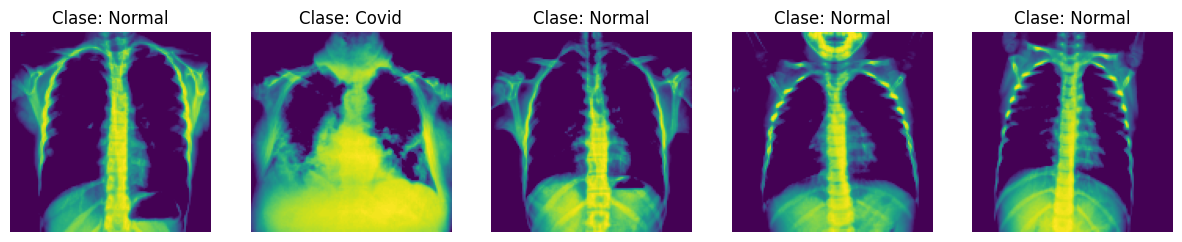

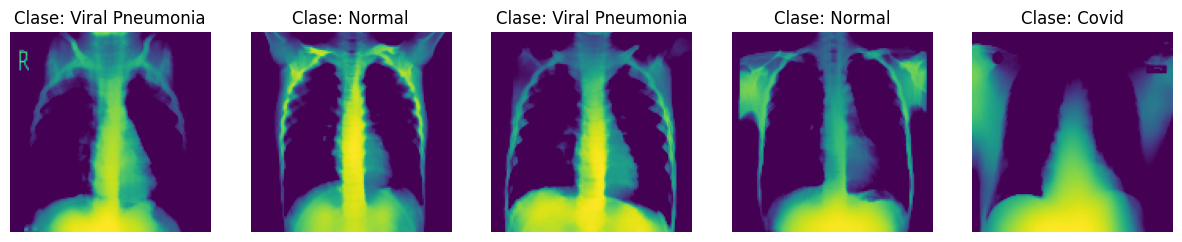

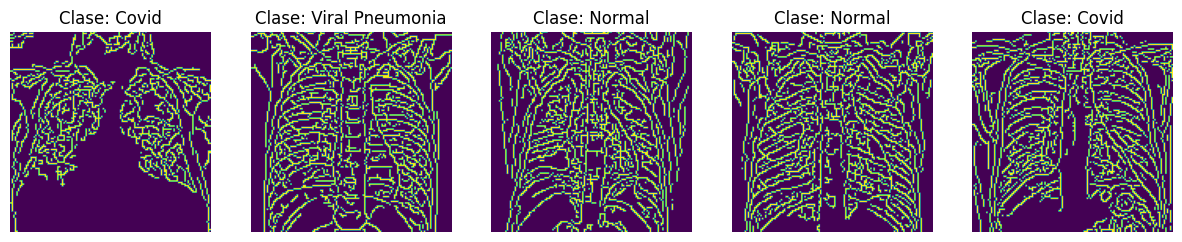

In [153]:
def show_first_five_images(data_loader, dataset):
    
    try:
        images, labels = next(iter(data_loader))
    
    except StopIteration:
        print("El DataLoader no tiene m√°s datos.")
    
    except Exception as e:
        print(f"Ocurri√≥ un error: {e}")
    
    images = images.numpy().transpose((0, 2, 3, 1))
    images = np.clip(images, 0, 1)

    _, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax, img, label in zip(axes, images[:5], labels[:5]):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Clase: {dataset.classes[label.item()]}')
    plt.show()

show_first_five_images(train_loader_r, train_dataset_r)
show_first_five_images(train_loader_b, train_dataset_b)
show_first_five_images(train_loader_c, train_dataset_c)


Se ve inusual porque `plt` asume que la imagen est√° en formato RGB, pero en realidad solo tiene un canal de color. Esto se debe a que el modelo est√° dise√±ado para aceptar entradas con solo un canal de color.

## Funci√≥n de entrenamiento

In [154]:
def train(model, train_data_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(EPOCHS):
        
        # Para llevar un registro de la p√©rdida por epoch
        epoch_loss = 0

        for images, labels in train_data_loader:

            # Limpiar gradientes: Se restablecen los gradientes acumulados en el optimizador a cero para evitar que se sumen a los gradientes del lote actual.
            optimizer.zero_grad()

            # Forward pass: Se pasan las im√°genes a trav√©s del modelo para obtener las predicciones (model_predictions).
            model_predictions = model(images)

            # print("Model predictions shape:", model_predictions.shape)
            # print("Labels shape:", labels.shape)

            # C√°lculo de la p√©rdida: Se calcula la p√©rdida utilizando la funci√≥n de p√©rdida definida anteriormente,
            # comparando las predicciones (model_predictions) con las etiquetas verdaderas (labels).
            loss = criterion(model_predictions, labels)
            
            # Sumar la p√©rdida de este lote a la p√©rdida total de la √©poca
            epoch_loss += loss.item()

            # Backward pass: Se realiza la propagaci√≥n hacia atr√°s para calcular los gradientes de la p√©rdida con respecto a los par√°metros del modelo.
            loss.backward()

            # Actualizar par√°metros: Se actualizan los par√°metros del modelo utilizando los gradientes calculados en la etapa anterior.
            optimizer.step()

        # Imprimir p√©rdida promedio por √©poca y el LR
        avg_loss = epoch_loss / len(train_data_loader)
        current_lr = optimizer.param_groups[0]['lr']  # Obtener el learning rate actual
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}, Learning Rate: {current_lr:.6f}')
        # print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {loss.item():.4f}')

        # Actualiza el scheduler con la p√©rdida promedio
        scheduler.step(avg_loss)

        wandb.log({
            f"{model_name}_epoch_loss": avg_loss
        }, commit=True)

- **mode**='min': El scheduler se activar√° si la p√©rdida se encuentra en su m√≠nimo.
- **factor**=0.5: Reducir√° el learning rate a la mitad.
- **patience**=2: Esperar√° 2 √©pocas antes de reducir el learning rate si no hay mejora.

## Funciones de evaluaci√≥n

In [155]:
def evaluate_model(model, test_data_loader):
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_data_loader:

            model_predictions = model(images)
            _, predicted = torch.max(model_predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()

# Modelo B

## Arquitectura 1

### Definici√≥n

#### Modelo 0

In [156]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(in_features=(128 * 16 * 16), out_features=64)
#         self.fc2 = nn.Linear(in_features=64, out_features=3)
#         self.dropout = nn.Dropout(DROPOUT_RATE)

#     def forward(self, x):
#                                                 # x = [32, 1, 128, 128]
#         x = self.pool(F.relu(self.conv1(x)))    # [32,1,128,128] -conv-> [32,32,128,128] -ReLu-> [32,32,128,128] -pooling-> [32,32,64,64]
#         x = self.pool(F.relu(self.conv2(x)))    # [32,32,64,64] -conv-> [32,64,64,64] -ReLu-> [32,64,64,64] -pooling-> [32,64,32,32]
#         x = self.pool(F.relu(self.conv3(x)))    # [32,64,32,32] -conv-> [32,128,32,32] -ReLu-> [32,128,32,32] -pooling-> [32,128,16,16]
#         x = x.view(-1, 128 * 16 * 16)           # [32,128,16,16] -view-> [32, 128*16*16]
#         x = F.relu(self.fc1(x))                 # [32, 128*16*16] -fc-> [32, 64]
#         x = self.dropout(x)                     # Aplicar Dropout
#         x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
#         return x

#### Modelo 1

In [157]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=(128 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN1.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 16, 16]
        # Etapa 2
        x = x.view(-1, 128 * 16 * 16)           # [32, 128, 16, 16] -view-> [32, 128*16*16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 128*16*16] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificaci√≥n

La arquitectura propuesta para esta CNN est√° dise√±ada de manera que logre un equilibrio entre simplicidad y capacidad de extracci√≥n de caracter√≠sticas en im√°genes. A continuaci√≥n, justifico las decisiones tomadas en la estructura del modelo:

##### 1. **Capas convolucionales (Conv2D)**
Se han utilizado tres capas convolucionales con un n√∫mero creciente de filtros (32, 128) y un tama√±o de kernel de 3x3, junto con un bloque Inception. Esta configuraci√≥n permite:
- **Extracci√≥n progresiva de caracter√≠sticas**: Al aumentar el n√∫mero de canales, la red puede capturar detalles de baja a alta complejidad a medida que las im√°genes pasan por las capas.
- **Receptive field**: El tama√±o de 3x3 es un est√°ndar eficaz que equilibra precisi√≥n y costo computacional, permitiendo que la red capture patrones locales en las im√°genes.

##### 2. **Bloque Inception**
La incorporaci√≥n de un bloque Inception permite que la red capture una variedad m√°s amplia de caracter√≠sticas a diferentes escalas. Las ventajas incluyen:
- **M√∫ltiples tama√±os de convoluci√≥n**: El bloque utiliza convoluciones con diferentes tama√±os de kernel (1x1, 3x3, 5x5) en paralelo, permitiendo que la red aprenda a detectar caracter√≠sticas en diversas escalas.
- **Reducci√≥n de dimensionalidad**: Las convoluciones de 1x1 ayudan a reducir el n√∫mero de canales, optimizando la carga computacional.

##### 3. **Max Pooling**
El uso de `MaxPool2D` con kernel 2x2 reduce las dimensiones espaciales de las im√°genes (de 128x128 a 16x16 tras 3 pasos), permitiendo:
- **Reducci√≥n de la dimensionalidad**: Lo cual es clave para disminuir el n√∫mero de par√°metros en las capas completamente conectadas (fully connected), evitando el sobreajuste.
- **Retenci√≥n de informaci√≥n importante**: El max pooling retiene los valores m√°ximos en cada regi√≥n, preservando caracter√≠sticas clave mientras descarta informaci√≥n redundante.

##### 4. **Capas completamente conectadas (Fully Connected)**
Se ha elegido un n√∫mero moderado de neuronas en las capas `fc1` (64) y `fc2` (3), con las siguientes razones:
- **Compactaci√≥n de las caracter√≠sticas**: La salida de la √∫ltima capa convolucional se transforma en un vector de caracter√≠sticas mediante `view`, y las capas fully connected resumen esta informaci√≥n en un formato √∫til para la clasificaci√≥n.
- **Reducci√≥n final a 3 clases**: La capa `fc2` genera una salida de 3 neuronas, correspondiente a las 3 categor√≠as del problema.

##### 5. **Dropout**
Se introduce dropout en las √∫ltimas iteraciones con el fin de:
- **Evitar el sobreajuste**: Dropout es una t√©cnica eficaz para mejorar la generalizaci√≥n del modelo, ya que previene la dependencia excesiva en ciertos patrones durante el entrenamiento.

##### 6. **Resultados experimentales**
El desempe√±o del modelo mejora notablemente a lo largo de las iteraciones al ajustar los hiperpar√°metros (learning rate, epochs) y al incluir dropout. Esto valida que la arquitectura es capaz de aprender representaciones √∫tiles cuando se le da suficiente tiempo de entrenamiento y se aplican t√©cnicas de regularizaci√≥n adecuadas.

##### 7. **Etapas**
Las **etapas** de esta red CNN se pueden dividir en tres bloques principales:

###### 1. **Etapa de extracci√≥n de caracter√≠sticas**
   - **Capas**: `conv1`, `inception1`, `conv2`, y `pool`
   - **Descripci√≥n**: Esta etapa utiliza capas convolucionales y de pooling para extraer caracter√≠sticas de la imagen de entrada. La activaci√≥n `ReLU` a√±ade no linealidad y el `MaxPool2D` reduce la dimensionalidad de los mapas de caracter√≠sticas.
     - Conv1: Extrae caracter√≠sticas iniciales de la imagen (bordes, texturas).
     - Inception1: Captura caracter√≠sticas en m√∫ltiples escalas.
     - Conv2: Extrae a√∫n m√°s caracter√≠sticas complejas.
     - MaxPool: Reduce la dimensi√≥n espacial despu√©s de cada convoluci√≥n.

###### 2. **Etapa de aplanamiento (Flattening)**
   - **Capas**: `x.view(-1, 128 * 16 * 16)`
   - **Descripci√≥n**: Aplana la salida de la √∫ltima capa convolucional en un vector para poder pasarla a las capas totalmente conectadas.

###### 3. **Etapa de clasificaci√≥n**
   - **Capas**: `fc1`, `dropout`, `fc2`
   - **Descripci√≥n**: Las capas completamente conectadas (`fc1` y `fc2`) se encargan de la clasificaci√≥n final. `fc1` reduce la dimensionalidad a 64 neuronas, y despu√©s se aplica un `dropout` para prevenir el sobreajuste. Finalmente, `fc2` produce la salida de 3 clases (asumiendo una clasificaci√≥n de 3 categor√≠as).

Estas tres etapas forman la estructura completa de la CNN.

##### Transformaci√≥n de `x` a trav√©s de la red
El tensor de entrada `x` tiene la forma `[N, C, H, W]`, donde:
- **N** = Batch size (n√∫mero de muestras).
- **C** = N√∫mero de canales.
- **H** = Altura de la entrada.
- **W** = Ancho de la entrada.

- **Input shape**: `[32, 1, 128, 128]`
1. `[32, 1, 128, 128]` ‚Üí **Conv1** ‚Üí `[32, 32, 128, 128]` ‚Üí **ReLU** ‚Üí `[32, 32, 128, 128]` ‚Üí **Pooling** ‚Üí `[32, 32, 64, 64]`
2. `[32, 32, 64, 64]` ‚Üí **Inception1** ‚Üí `[32, 128, 64, 64]` ‚Üí **Pooling** ‚Üí `[32, 128, 32, 32]`
3. `[32, 128, 32, 32]` ‚Üí **Conv2** ‚Üí `[32, 128, 32, 32]` ‚Üí **ReLU** ‚Üí `[32, 128, 32, 32]` ‚Üí **Pooling** ‚Üí `[32, 128, 16, 16]`
4. `[32, 128, 16, 16]` ‚Üí **View** ‚Üí `[32, 128 * 16 * 16]`
5. `[32, 128 * 16 * 16]` ‚Üí **Fully Connected (fc1)** ‚Üí `[32, 64]`
6. `[32, 64]` ‚Üí **Fully Connected (fc2)** ‚Üí `[32, 3]`

###### `x.view()` function:
La funci√≥n `view()` en PyTorch se utiliza para cambiar la forma de un tensor sin alterar sus datos subyacentes.
Transforma el tensor de entrada de una forma 4D `[N, C, H, W]` a una forma 2D `[N, F]`, donde:
- **F** = N√∫mero de caracter√≠sticas (features).
El n√∫mero de caracter√≠sticas se calcula como:
\[
F = C \times H \times W
\]

#### Explicaci√≥n de las capas

##### Capas de Pooling
Una capa de pooling reduce la dimensionalidad del mapa de caracter√≠sticas generado por la capa de convoluci√≥n. Funciona tomando un subconjunto de valores (por ejemplo, el valor m√°ximo o promedio) dentro de una ventana deslizante, lo que disminuye el tama√±o de la representaci√≥n. Esto ayuda a preservar las caracter√≠sticas m√°s importantes mientras se descartan detalles menos relevantes.
La reducci√≥n en la dimensionalidad tambi√©n mejora la eficiencia computacional y ayuda a prevenir el sobreajuste. En resumen, el pooling simplifica la representaci√≥n y permite que el modelo se enfoque en las caracter√≠sticas m√°s significativas.

###### C√°lculo de la Dimensionalidad:
\begin{aligned}
d' = \frac{d - k}{s} + 1
\end{aligned}

Par√°metros:
- **d -> dimension_in**: Es el tama√±o de la dimension de entrada
- **k -> kernel_size**: Es el tama√±o del kernel (matriz de orden $k^2$).
- **s -> stride**: El n√∫mero de p√≠xeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un p√≠xel a la vez.
- **d' -> dimension_out**: Es el tama√±o de la dimension de salida.

##### Capas de convoluci√≥n
Una capa de convoluci√≥n extrae caracter√≠sticas de la imagen de entrada mediante filtros que se deslizan sobre la misma. 
Aplica una operaci√≥n matem√°tica llamada convoluci√≥n, produciendo un mapa de caracter√≠sticas que resalta patrones como bordes y texturas. 
Mantiene la estructura espacial de la imagen, permitiendo que el modelo aprenda relaciones espaciales. 
Generalmente, se le aplica una funci√≥n de activaci√≥n (como ReLU) para introducir no linealidades.

###### C√°lculo de la Dimensionalidad:
\begin{aligned}
d' = \frac{d + 2p - k}{s} + 1
\end{aligned}

Par√°metros:
- **k -> kernel_size**: Es el orden de una matriz cuadrada.
- **s -> stride**: El n√∫mero de p√≠xeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un p√≠xel a la vez.
- **p -> padding**: El n√∫mero de p√≠xeles a√±adidos alrededor de la imagen de entrada para mantener las dimensiones de salida. El padding ayuda a prevenir que la imagen se reduzca demasiado despu√©s de la convoluci√≥n, permitiendo una mejor retenci√≥n de informaci√≥n en los bordes.


##### Capas Fully Connected
Una capa totalmente conectada (fully connected layer) conecta cada neurona de la capa anterior a cada neurona de la capa actual. Se utiliza para combinar las caracter√≠sticas extra√≠das por las capas previas y realizar la clasificaci√≥n o regresi√≥n. 
Cada neurona en esta capa aplica una transformaci√≥n lineal a las entradas, seguida de una funci√≥n de activaci√≥n, lo que permite al modelo aprender patrones complejos. Las capas totalmente conectadas suelen encontrarse al final de una red neuronal, despu√©s de las capas de convoluci√≥n y pooling.
En resumen, estas capas integran la informaci√≥n y producen la salida final del modelo.


##### Capa Dropout
La capa `Dropout` es una t√©cnica de regularizaci√≥n utilizada para prevenir el sobreajuste durante el entrenamiento de redes neuronales. En cada paso de entrenamiento, desactiva aleatoriamente un porcentaje de neuronas (definido por `DROPOUT_RATE`), lo que obliga a la red a no depender demasiado de una sola neurona. Esto mejora la generalizaci√≥n del modelo, ayudando a que aprenda patrones m√°s robustos. En esta CNN, se aplica despu√©s de la primera capa completamente conectada para mejorar el rendimiento en tareas de clasificaci√≥n.

### Creaci√≥n de los modelos (Raw, Bilateral y Canny)

In [158]:
model_b_a1_r = CNN1()  # Modelo para datos crudos
model_b_a1_b = CNN1()  # Modelo para datos con filtro bilateral
model_b_a1_c = CNN1()  # Modelo para datos con filtro Canny

### Viusalizaci√≥n del modelo B-A1

In [159]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a1_r(x)

dot = make_dot(y, params=dict(list(model_b_a1_r.named_parameters())))
file_name = 'model_b_a1_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a1_graph.png'

### Entrenamiento B-A1

In [160]:
wandb.watch(model_b_a1_r, log="all")
print("Training model B-A1 Raw")
train(model=model_b_a1_r ,train_data_loader=train_sub_loader_r, model_name=model_b_a1_r)
print()
wandb.unwatch(model_b_a1_r)

wandb.watch(model_b_a1_b, log="all")
print("Training model B-A1 Bilateral")
train(model=model_b_a1_b ,train_data_loader=train_sub_loader_b, model_name=model_b_a1_b)
print()
wandb.unwatch(model_b_a1_b)

wandb.watch(model_b_a1_c, log="all")
print("Training model B-A1 Canny")
train(model=model_b_a1_c ,train_data_loader=train_sub_loader_c, model_name=model_b_a1_c)
print()
wandb.unwatch(model_b_a1_c)

Training model B-A1 Raw


C:\Users\PC MASTER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.1061, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0965, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0260, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.9640, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.8078, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.5510, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.3509, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.4347, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.6284, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.2398, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.1301, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.0862, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.0736, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.2060, Learning Rate: 0.001000
Epoch [15/20], Loss: 0.0515, Learning Rate: 0.001000
Epoch [16/20], Loss: 0.1186, Learning Rate: 0.001000
Epoch [17/20], Loss: 0.0298, Learning Rate: 0.001000
Epoch [18/20], Loss: 0.0691, Learning Rate: 0.001000
Epoch [19/20], Loss: 0.1708, Learning Rate: 0.001000
Ep

### Evaluaci√≥n B-A1

In [161]:
print("Evaluating model B-A1 Raw")
evaluate_model(model=model_b_a1_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A1 Bilateral")
evaluate_model(model=model_b_a1_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A1 Canny")
evaluate_model(model=model_b_a1_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A1 Raw
Accuracy of the model on the test images: 72.73%

Evaluating model B-A1 Bilateral
Accuracy of the model on the test images: 63.64%

Evaluating model B-A1 Canny
Accuracy of the model on the test images: 62.12%



### Matriz de confusi√≥n

Evaluando modelo B-A1 Raw


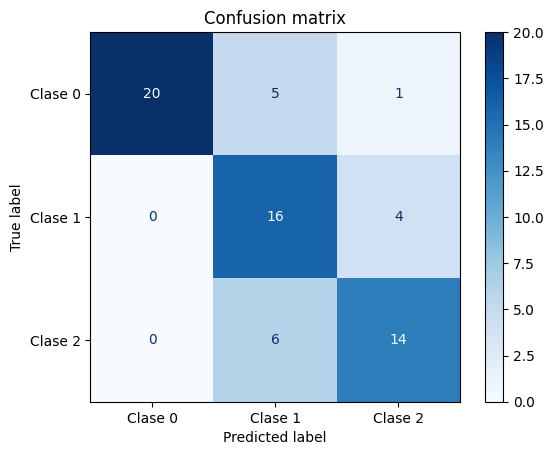

Evaluando modelo B-A1 Bilateral


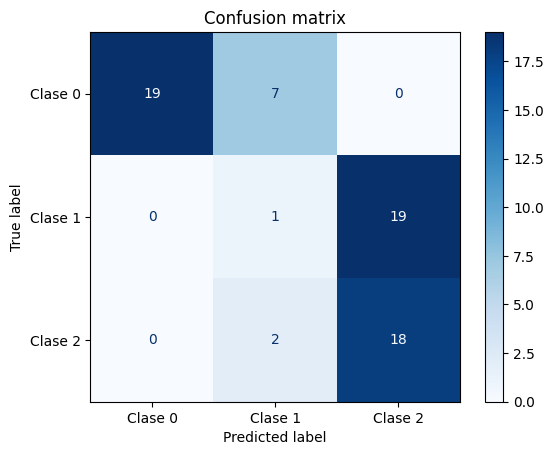

Evaluando modelo B-A1 Canny


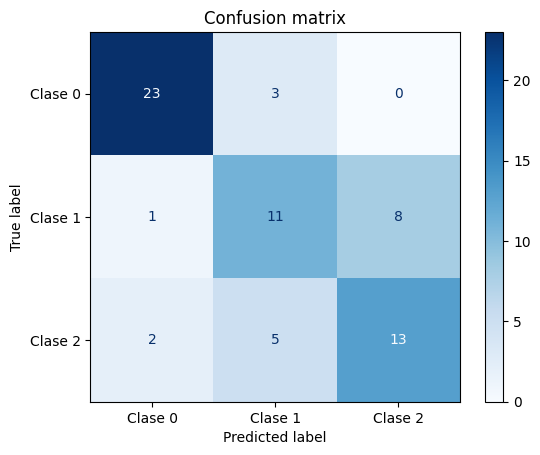

In [162]:
print("Evaluando modelo B-A1 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a1_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A1 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a1_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A1 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a1_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

## Arquitectura 2

### Definici√≥n

In [163]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=(256 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN2.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.inception1(x)                  # [32, 32, 64, 64] -incep-> [32, 128, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 64, 64] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))    # [32, 128, 32, 32] -conv-> [32, 256, 32, 32] -ReLu-> same -pooling-> [32, 256, 16, 16]
        # Etapa 2
        x = x.view(-1, 256 * 16 * 16)           # [32, 256, 16, 16] -view-> [32, 256 * 16 * 16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 256 * 16 * 16] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

### Creaci√≥n de los modelos (Raw, Bilateral y Canny)

In [164]:
model_b_a2_r = CNN2()  # Modelo para datos crudos
model_b_a2_b = CNN2()  # Modelo para datos con filtro bilateral
model_b_a2_c = CNN2()  # Modelo para datos con filtro Canny

### Viusalizaci√≥n del modelo B-A2

In [165]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a2_r(x)

dot = make_dot(y, params=dict(list(model_b_a2_r.named_parameters())))
file_name = 'model_b_a2_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a2_graph.png'

### Entrenamiento B-A2

In [166]:
wandb.watch(model_b_a2_r, log="all")
print("Training model B-A2 Raw")
train(model=model_b_a2_r ,train_data_loader=train_sub_loader_r, model_name=model_b_a2_r)
print()
wandb.unwatch(model_b_a2_r)

wandb.watch(model_b_a2_b, log="all")
print("Training model B-A2 Bilateral")
train(model=model_b_a2_b ,train_data_loader=train_sub_loader_b, model_name=model_b_a2_b)
print()
wandb.unwatch(model_b_a2_b)

wandb.watch(model_b_a2_c, log="all")
print("Training model B-A2 Canny")
train(model=model_b_a2_c ,train_data_loader=train_sub_loader_c, model_name=model_b_a2_c)
print()
wandb.unwatch(model_b_a2_c)

Training model B-A2 Raw


C:\Users\PC MASTER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.0752, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.5433, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.1367, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0133, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0048, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.8100, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.5578, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.4207, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.2875, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.0949, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.1992, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.3518, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.1777, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.0938, Learning Rate: 0.000500
Epoch [15/20], Loss: 0.0692, Learning Rate: 0.000500
Epoch [16/20], Loss: 0.0349, Learning Rate: 0.000500
Epoch [17/20], Loss: 0.4061, Learning Rate: 0.000500
Epoch [18/20], Loss: 0.1084, Learning Rate: 0.000500
Epoch [19/20], Loss: 0.0159, Learning Rate: 0.000500
Ep

### Evaluaci√≥n B-A2

In [167]:
print("Evaluating model B-A2 Raw")
evaluate_model(model=model_b_a2_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A2 Bilateral")
evaluate_model(model=model_b_a2_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A2 Canny")
evaluate_model(model=model_b_a2_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A2 Raw
Accuracy of the model on the test images: 66.67%

Evaluating model B-A2 Bilateral
Accuracy of the model on the test images: 59.09%

Evaluating model B-A2 Canny
Accuracy of the model on the test images: 68.18%



### Matriz de confusi√≥n

Evaluando modelo B-A2 Raw


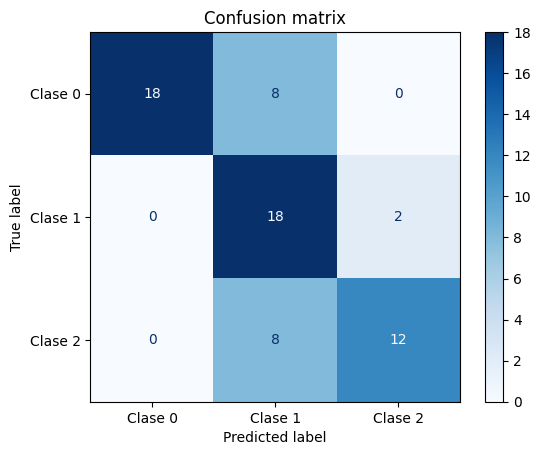

Evaluando modelo B-A2 Bilateral


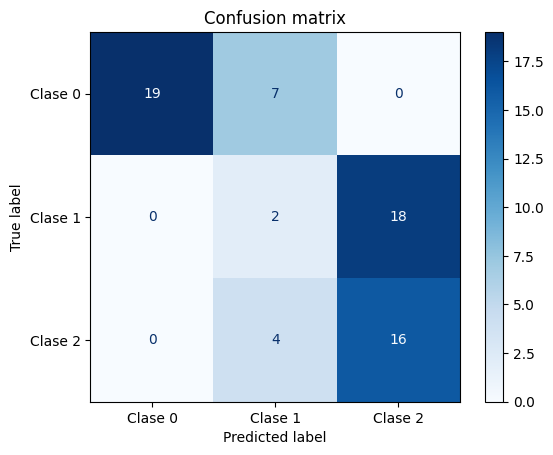

Evaluando modelo B-A2 Canny


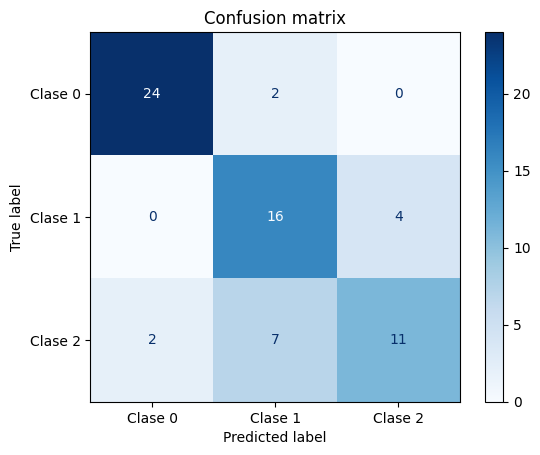

In [168]:
print("Evaluando modelo B-A2 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a2_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A2 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a2_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A2 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a2_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

## Arquitectura 3

### Definici√≥n

In [169]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(in_features=(512 * 8 * 8), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(DROPOUT_RATE)

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN3.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 256, 32, 32] -ReLu-> same -pooling-> [32, 256, 16, 16]
        x = self.pool(F.relu(self.conv3(x)))    # [32, 256, 16, 16] -conv-> [32, 512, 16, 16] -ReLu-> same -pooling-> [32, 512, 8, 8]
        # Etapa 2
        x = x.view(-1, 512 * 8 * 8)             # [32, 512, 8, 8] -view-> [32, 512 * 8 * 8]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 512 * 8 * 8] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

### Creaci√≥n de los modelos (Raw, Bilateral y Canny)

In [170]:
model_b_a3_r = CNN3()  # Modelo para datos crudos
model_b_a3_b = CNN3()  # Modelo para datos con filtro bilateral
model_b_a3_c = CNN3()  # Modelo para datos con filtro Canny

### Viusalizaci√≥n del modelo B-A3

In [171]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a3_r(x)

dot = make_dot(y, params=dict(list(model_b_a3_r.named_parameters())))
file_name = 'model_b_a3_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a3_graph.png'

### Entrenamiento B-A3

In [172]:
wandb.watch(model_b_a3_r, log="all")
print("Training model B-A3 Raw")
train(model=model_b_a3_r ,train_data_loader=train_sub_loader_r, model_name=model_b_a3_r)
print()
wandb.unwatch(model_b_a3_r)

wandb.watch(model_b_a3_b, log="all")
print("Training model B-A3 Bilateral")
train(model=model_b_a3_b ,train_data_loader=train_sub_loader_b, model_name=model_b_a3_b)
print()
wandb.unwatch(model_b_a3_b)


wandb.watch(model_b_a3_c, log="all")
print("Training model B-A3 Canny")
train(model=model_b_a3_c ,train_data_loader=train_sub_loader_c, model_name=model_b_a3_c)
print()
wandb.unwatch(model_b_a3_c)

Training model B-A3 Raw


C:\Users\PC MASTER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.1010, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.2478, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0729, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0561, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0497, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.9784, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.8092, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.5527, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.4872, Learning Rate: 0.001000
Epoch [10/20], Loss: 1.1236, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.3993, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.3761, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.2427, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.2458, Learning Rate: 0.001000
Epoch [15/20], Loss: 0.2344, Learning Rate: 0.001000
Epoch [16/20], Loss: 0.2612, Learning Rate: 0.001000
Epoch [17/20], Loss: 0.2167, Learning Rate: 0.001000
Epoch [18/20], Loss: 0.2374, Learning Rate: 0.001000
Epoch [19/20], Loss: 0.2209, Learning Rate: 0.001000
Ep

### Evaluaci√≥n B-A3

In [173]:
print("Evaluating model B-A3 Raw")
evaluate_model(model=model_b_a3_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A3 Bilateral")
evaluate_model(model=model_b_a3_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A3 Canny")
evaluate_model(model=model_b_a3_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A3 Raw
Accuracy of the model on the test images: 77.27%

Evaluating model B-A3 Bilateral
Accuracy of the model on the test images: 65.15%

Evaluating model B-A3 Canny
Accuracy of the model on the test images: 65.15%



### Matriz de confusi√≥n

Evaluando modelo B-A3 Raw


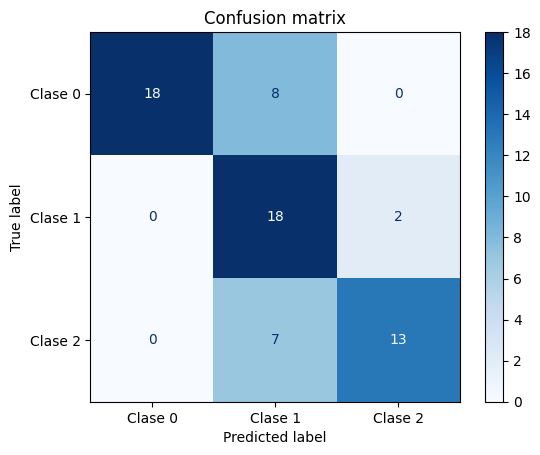

Evaluando modelo B-A3 Bilateral


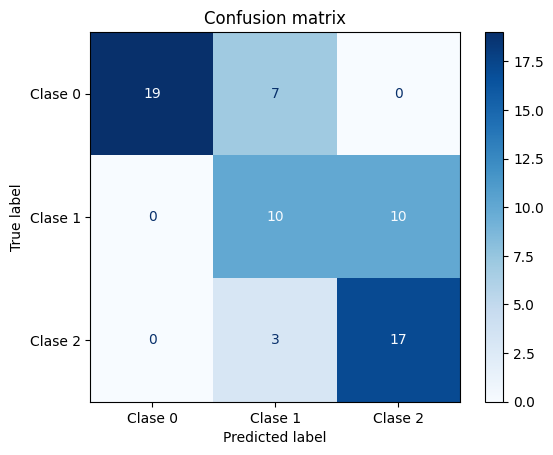

Evaluando modelo B-A3 Canny


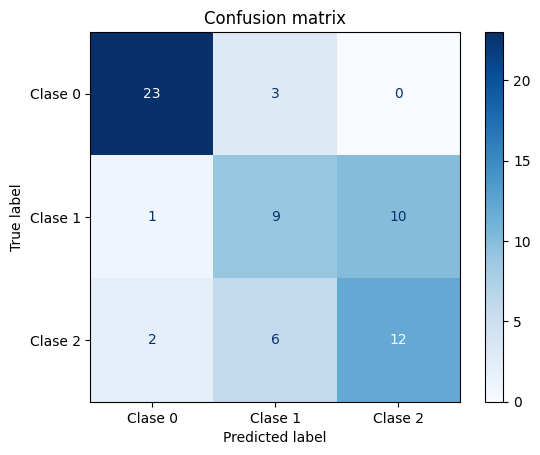

In [174]:
print("Evaluando modelo B-A3 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a3_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A3 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a3_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A3 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a3_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

In [175]:
wandb.finish()

# An√°lisis

## 1. **CNN1**: 
   - Esta red comienza con una capa convolucional que tiene 32 filtros, seguida de un bloque Inception. El bloque Inception toma la entrada de 32 canales y la expande a 128 canales combinando varias convoluciones (1x1, 3x3, 5x5) y una operaci√≥n de pooling.
   - Luego, tiene una segunda capa convolucional de 128 canales. 
   - Despu√©s del procesamiento convolucional, los datos se transforman mediante capas totalmente conectadas (fully connected), comenzando con una capa de 64 neuronas y finalizando con la capa de salida que tiene 3 neuronas, lo que indica que se est√° trabajando con un problema de clasificaci√≥n de tres clases.
   - Las dimensiones de las im√°genes se reducen progresivamente por medio de operaciones de "pooling" y "view", hasta que los datos son transformados para pasar por las capas fully connected.

### **Pros**:
  - Arquitectura simple y menos profunda, lo que la hace m√°s r√°pida de entrenar.
  - Menor riesgo de sobreajuste, ya que tiene menos par√°metros que las otras redes.
  - Menor consumo de recursos computacionales (memoria y tiempo de entrenamiento).
### **Contras**:
  - Menor capacidad para aprender caracter√≠sticas complejas, lo que puede limitar su rendimiento en problemas m√°s dif√≠ciles.
  - Menos filtros y capas pueden hacerla menos precisa en tareas de clasificaci√≥n m√°s complejas.


## 2. **CNN2**:
   - En este modelo, la arquitectura es similar a CNN1, pero incluye una tercera capa convolucional adicional. Despu√©s de la segunda capa convolucional con 128 filtros, CNN2 aplica una tercera convoluci√≥n que incrementa los canales a 256.
   - La primera parte de la red sigue siendo casi id√©ntica: una capa convolucional, un bloque Inception y una segunda convoluci√≥n. Sin embargo, la tercera convoluci√≥n aumenta la capacidad del modelo para extraer caracter√≠sticas m√°s complejas.
   - Al final, la red transforma los datos con una capa fully connected de 64 neuronas, seguida de la capa de salida de 3 neuronas.

### **Pros**:
  - Mayor capacidad que CNN1 gracias a la adici√≥n de una tercera capa convolucional con m√°s filtros.
  - Puede aprender caracter√≠sticas m√°s complejas, lo que mejora su desempe√±o en problemas m√°s dif√≠ciles.
  - Aumenta la complejidad sin ser excesivamente pesada en t√©rminos de c√≥mputo.
### **Contras**:
  - Mayor riesgo de sobreajuste comparado con CNN1, ya que tiene m√°s par√°metros.
  - Consume m√°s recursos (memoria y tiempo de entrenamiento) que CNN1.


## 3. **CNN3**:
   - Este modelo es el m√°s profundo de los tres. Tras la capa convolucional inicial y el bloque Inception, tiene una segunda convoluci√≥n que aumenta los canales a 256 (similar a CNN2), pero adem√°s, a√±ade una tercera capa convolucional que incrementa los canales a 512.
   - El tama√±o de las caracter√≠sticas se reduce progresivamente con cada operaci√≥n de "pooling", y despu√©s de la tercera convoluci√≥n, las dimensiones son mucho menores (8x8), lo que implica que CNN3 est√° preparada para aprender caracter√≠sticas m√°s abstractas.
   - Finalmente, la red tiene las capas fully connected y de salida, similares a CNN2, pero con una mayor cantidad de informaci√≥n procesada en las etapas previas.

### **Pros**:
  - La arquitectura m√°s profunda y con m√°s filtros la hace m√°s poderosa para capturar caracter√≠sticas abstractas y complejas.
  - Potencialmente mejor desempe√±o en tareas con patrones complicados o grandes cantidades de datos.
### **Contras**:
  - Alto riesgo de sobreajuste si no se cuenta con suficientes datos o t√©cnicas de regularizaci√≥n.
  - Mayor demanda de recursos computacionales, con tiempos de entrenamiento m√°s largos y mayor uso de memoria.
  - Puede ser innecesaria para tareas simples, donde una red menos profunda ser√≠a m√°s eficiente.
